# Load libraries and set parameters

In [11]:
import torch
from torch import nn
import torch.nn.functional as F

import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
from torchinfo import summary

import torchvision
from torch import optim, nn
import timeit



RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

# Expansion of the MLP 
EXPANSION = 128



random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "cuda" if torch.cuda.is_available() else "cpu"



# Patch Embedding class

In [69]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            # We use conv instead of linear for efficiency
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                # if kernel_size = stride -> no overlap
                kernel_size=patch_size,
                stride=patch_size
            ),
            # Linear projection of Flattened Patches. We keep the batch and we channels (b,c,h,w)
            nn.Flatten(2))
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Create a copy of the cls token for each of the elements of the BATCH
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # Create the patches
        x = self.patcher(x).permute(0, 2, 1)
        # Unify the position with the patches
        x = torch.cat([cls_token, x], dim=1)
        # Patch + Position Embedding
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)


# ViT using PyTorch functions

In [70]:
class ViT_PyTorch(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, expansion, num_classes):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, dim_feedforward=int(embed_dim*expansion), activation="gelu", batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


In [71]:
model1 = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)

In [73]:

print("\nSummary of the model1 (using PyTorch functions):")
summary(model1, input_size=(1, 1, 28, 28))


Summary of the model1 (using PyTorch functions):


Layer (type:depth-idx)                        Output Shape              Param #
ViT_PyTorch                                   [1, 10]                   --
├─PatchEmbedding: 1-1                         [1, 50, 16]               816
│    └─Sequential: 2-1                        [1, 16, 49]               --
│    │    └─Conv2d: 3-1                       [1, 16, 7, 7]             272
│    │    └─Flatten: 3-2                      [1, 16, 49]               --
│    └─Dropout: 2-2                           [1, 50, 16]               --
├─TransformerEncoder: 1-2                     [1, 50, 16]               --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-3      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-4      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-5      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-6      [1, 50, 16]               68,752
├─

# Load EMNIST dataset

In [16]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Random rotation for training data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
val_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=val_test_transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=val_test_transform)





Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 16071907.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 473988.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4383002.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 2726567.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [17]:
train_dataset = Subset(train_data, range(48000))
val_dataset = Subset(val_data, range(48000, len(val_data)))

In [18]:
num_workers = torch.cuda.device_count() * 4
num_workers

4

In [74]:
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                        num_workers=num_workers, pin_memory=False,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

# Training

In [75]:
model1 = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)


In [76]:
EPOCHS = 50
print("Showing the first 30 elements of each epoch!")
# Save losses and accuracies for plot
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model1.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, (data, target) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = data.float().to(device)
        label = target.type(torch.uint8).to(device)
        optimizer.zero_grad()
        y_pred = model1(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        loss = criterion(y_pred, label)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (idx + 1)
    
    # Saving metrics of training
    train_accuracy = sum(1 for x,y in zip(train_preds, train_labels) if x==y) / len(train_labels)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    
    

    model1.eval()
    
    # Validation
    
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = data.float().to(device)
            label = target.type(torch.uint8).to(device)
            y_pred = model1(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

    val_loss = val_running_loss / (idx + 1)
    
    # Saving metrics of validation
    val_accuracy = sum(1 for x,y in zip(val_preds, val_labels) if x==y) / len(val_labels)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Showing labels while training
    train_labels_array =  np.array([y.detach().numpy() for y in train_labels])
    train_preds_array = np.array([y.detach().numpy() for y in train_preds])
    val_labels_array =  np.array([y.detach().numpy() for y in val_labels])
    val_preds_array = np.array([y.detach().numpy() for y in val_preds])
    print("*" * 30)
    print(f"EPOCH {epoch+1}")
    print("Training predictions:   ", train_preds_array[:30])
    print("Training labels:        ", train_labels_array[:30])
    print("Validation predictions: ", val_preds_array[:30])
    print("Validation labels:      ", val_labels_array[:30])
    print("-" * 30)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Accuracy: {val_accuracy:.4f}")
    print("*" * 30)

     
stop= timeit.default_timer()
print(f"Training Time: {stop-start:.2f} s")

Showing the first 30 elements of each epoch!


  2%|▏         | 1/50 [00:10<08:22, 10.25s/it]

******************************
EPOCH 1
Training predictions:    [6 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8]
Training labels:         [0 5 5 1 7 3 4 6 7 4 1 8 8 3 1 3 7 2 0 9 0 0 6 2 2 9 2 3 7 6]
Validation predictions:  [7 7 7 4 7 8 0 0 9 8 8 1 1 0 7 4 8 7 4 8 8 7 7 6 6 7 7 8 8 4]
Validation labels:       [7 7 7 4 7 2 5 0 0 8 5 1 1 9 7 9 4 8 4 7 3 7 1 2 5 7 7 5 7 5]
------------------------------
Train Loss: 2.1673
Valid Loss: 1.8086
Train Accuracy: 0.2062
Valid Accuracy: 0.4028
******************************


  4%|▍         | 2/50 [00:20<08:10, 10.21s/it]

******************************
EPOCH 2
Training predictions:    [8 1 8 1 7 7 5 9 1 7 6 0 1 1 7 7 2 2 9 8 1 2 1 0 8 7 6 1 7 4]
Training labels:         [5 6 9 1 7 7 5 4 1 7 6 0 6 2 7 7 3 8 8 3 9 2 1 5 3 7 3 1 0 9]
Validation predictions:  [0 4 7 0 1 7 7 8 2 8 6 4 1 0 4 9 0 7 4 1 1 1 8 7 3 1 0 6 6 0]
Validation labels:       [2 9 9 0 9 7 7 5 2 9 6 9 1 0 4 9 0 7 4 1 1 1 8 7 3 1 0 6 6 0]
------------------------------
Train Loss: 1.6030
Valid Loss: 1.3565
Train Accuracy: 0.4871
Valid Accuracy: 0.6034
******************************


  6%|▌         | 3/50 [00:30<07:58, 10.18s/it]

******************************
EPOCH 3
Training predictions:    [3 6 1 8 4 7 3 4 7 6 7 6 1 0 2 7 8 3 0 1 8 1 8 1 9 4 4 0 1 0]
Training labels:         [3 6 1 3 4 1 0 4 7 6 7 6 1 3 2 7 8 3 3 1 8 2 8 1 4 9 5 0 1 0]
Validation predictions:  [2 6 3 1 9 8 1 0 8 0 1 3 0 3 3 4 0 1 3 2 1 9 3 4 6 8 0 4 6 7]
Validation labels:       [2 6 0 1 9 8 1 0 8 0 1 3 0 3 3 4 0 1 3 4 1 9 8 6 6 8 0 4 6 7]
------------------------------
Train Loss: 1.3264
Valid Loss: 1.1332
Train Accuracy: 0.6215
Valid Accuracy: 0.7200
******************************


  8%|▊         | 4/50 [00:40<07:48, 10.18s/it]

******************************
EPOCH 4
Training predictions:    [9 7 9 9 2 0 2 5 3 5 0 9 2 9 4 7 3 9 5 1 3 0 4 0 1 3 9 1 9 8]
Training labels:         [9 7 5 5 4 0 2 5 3 4 0 4 2 4 4 7 8 7 3 1 8 0 4 0 1 3 9 1 4 9]
Validation predictions:  [9 7 8 2 5 0 8 0 1 2 9 2 8 7 4 9 6 7 1 6 7 9 1 2 9 1 8 3 6 1]
Validation labels:       [9 7 8 2 5 0 5 0 1 2 9 2 9 9 4 9 6 7 1 6 7 9 1 2 9 1 8 7 6 4]
------------------------------
Train Loss: 1.1482
Valid Loss: 0.9859
Train Accuracy: 0.6939
Valid Accuracy: 0.7598
******************************


 10%|█         | 5/50 [00:50<07:38, 10.18s/it]

******************************
EPOCH 5
Training predictions:    [0 6 9 8 3 2 4 0 9 8 8 7 4 6 8 8 4 6 9 9 9 2 8 7 1 1 2 8 9 9]
Training labels:         [0 6 4 8 3 2 4 0 4 5 8 7 4 6 2 8 6 6 9 9 9 2 2 7 1 1 5 8 2 9]
Validation predictions:  [2 1 7 1 3 9 2 8 3 0 7 1 4 1 2 2 1 3 3 4 0 4 0 3 7 3 1 1 7 1]
Validation labels:       [2 1 7 1 3 9 2 8 5 0 9 1 4 1 2 5 1 3 5 4 0 4 0 3 2 8 1 1 7 1]
------------------------------
Train Loss: 1.0291
Valid Loss: 0.8721
Train Accuracy: 0.7344
Valid Accuracy: 0.8029
******************************


 12%|█▏        | 6/50 [01:01<07:33, 10.30s/it]

******************************
EPOCH 6
Training predictions:    [2 0 0 3 3 3 3 1 3 1 8 2 4 7 9 6 2 1 5 3 4 5 3 9 6 7 1 2 3 5]
Training labels:         [9 0 0 3 5 3 3 1 8 1 3 2 4 7 7 6 2 1 5 3 4 9 3 9 6 9 1 2 2 5]
Validation predictions:  [3 8 6 6 4 3 0 5 2 1 2 0 9 2 6 7 4 1 7 7 3 3 1 9 1 3 8 4 1 3]
Validation labels:       [3 8 6 6 4 3 0 5 4 4 6 0 9 2 6 9 4 1 7 7 3 5 1 9 1 3 8 4 1 5]
------------------------------
Train Loss: 0.9210
Valid Loss: 0.7639
Train Accuracy: 0.7697
Valid Accuracy: 0.8283
******************************


 14%|█▍        | 7/50 [01:11<07:23, 10.32s/it]

******************************
EPOCH 7
Training predictions:    [2 5 4 4 1 0 4 5 9 4 3 4 3 8 8 3 5 8 2 1 0 2 6 2 1 3 8 1 8 8]
Training labels:         [8 5 9 4 1 0 9 5 9 4 3 4 3 8 4 3 5 5 2 1 0 2 6 2 1 0 8 1 6 4]
Validation predictions:  [1 0 3 9 5 7 4 8 6 5 0 2 8 1 5 8 5 8 1 1 2 5 8 9 1 5 8 0 2 2]
Validation labels:       [1 0 3 9 5 7 4 3 8 5 0 2 8 8 5 8 5 8 8 1 2 3 3 9 1 5 8 0 2 2]
------------------------------
Train Loss: 0.8213
Valid Loss: 0.6832
Train Accuracy: 0.8029
Valid Accuracy: 0.8588
******************************


 16%|█▌        | 8/50 [01:22<07:12, 10.29s/it]

******************************
EPOCH 8
Training predictions:    [1 2 8 7 7 1 5 9 3 0 1 2 2 4 1 9 5 1 5 9 4 1 1 2 5 6 6 4 3 4]
Training labels:         [1 2 8 7 4 1 3 9 3 0 1 2 2 9 1 9 5 1 5 9 5 1 1 2 5 0 6 4 3 4]
Validation predictions:  [7 0 0 5 3 1 7 3 4 0 5 3 4 8 9 5 0 9 3 5 6 3 7 5 7 9 8 1 5 8]
Validation labels:       [7 0 0 5 3 4 2 3 4 0 5 3 4 8 4 6 0 9 3 5 6 3 7 5 7 9 8 1 5 8]
------------------------------
Train Loss: 0.7399
Valid Loss: 0.6032
Train Accuracy: 0.8252
Valid Accuracy: 0.8848
******************************


 18%|█▊        | 9/50 [01:32<07:04, 10.36s/it]

******************************
EPOCH 9
Training predictions:    [7 5 1 8 8 0 9 5 2 3 0 2 6 1 2 8 1 4 6 4 7 7 7 6 8 5 9 9 2 8]
Training labels:         [7 5 1 7 3 0 9 3 2 3 0 2 6 1 2 3 1 4 6 4 7 7 7 6 8 3 9 9 2 1]
Validation predictions:  [9 8 3 6 2 2 7 3 7 4 5 8 7 4 1 5 7 0 3 1 7 5 7 6 0 3 3 1 1 2]
Validation labels:       [9 8 3 6 2 2 7 3 7 4 0 8 7 4 1 5 7 9 3 1 7 5 7 6 0 3 3 1 1 2]
------------------------------
Train Loss: 0.6796
Valid Loss: 0.5438
Train Accuracy: 0.8414
Valid Accuracy: 0.8946
******************************


 20%|██        | 10/50 [01:42<06:54, 10.37s/it]

******************************
EPOCH 10
Training predictions:    [2 1 5 4 7 9 3 4 6 2 5 9 4 6 8 6 5 7 1 4 2 2 5 0 2 0 4 8 1 1]
Training labels:         [2 1 5 4 9 9 3 4 6 2 8 9 4 6 8 6 8 7 1 4 2 2 6 0 2 0 4 8 1 1]
Validation predictions:  [1 6 7 2 8 0 5 2 4 2 8 9 3 8 6 5 3 7 4 8 0 7 2 1 8 0 2 2 7 5]
Validation labels:       [1 6 7 2 8 0 5 2 4 2 8 9 3 8 6 5 5 7 4 8 6 7 2 1 8 0 2 2 7 5]
------------------------------
Train Loss: 0.6245
Valid Loss: 0.5113
Train Accuracy: 0.8526
Valid Accuracy: 0.8902
******************************


 22%|██▏       | 11/50 [01:53<06:43, 10.34s/it]

******************************
EPOCH 11
Training predictions:    [0 3 5 8 3 1 9 3 3 0 0 9 7 1 0 6 2 5 4 1 3 2 3 6 5 5 3 5 3 9]
Training labels:         [0 8 5 8 3 1 9 3 3 0 0 1 7 1 0 6 2 5 4 1 5 2 5 6 5 5 3 5 3 9]
Validation predictions:  [9 5 4 4 7 7 1 5 9 9 3 6 4 9 4 0 0 2 2 7 8 3 8 5 4 8 3 0 4 4]
Validation labels:       [9 5 4 4 7 7 1 9 9 9 3 6 4 9 4 0 0 2 2 7 8 3 8 5 4 4 3 0 4 4]
------------------------------
Train Loss: 0.5737
Valid Loss: 0.4698
Train Accuracy: 0.8657
Valid Accuracy: 0.9015
******************************


 24%|██▍       | 12/50 [02:04<06:41, 10.58s/it]

******************************
EPOCH 12
Training predictions:    [7 9 2 9 0 4 5 1 2 7 8 7 7 2 1 1 3 0 9 3 0 7 8 1 5 6 4 0 4 3]
Training labels:         [2 4 2 8 0 4 5 1 2 7 8 7 7 2 1 1 3 0 9 3 0 7 8 1 3 6 4 0 4 3]
Validation predictions:  [5 6 6 2 2 2 8 7 9 1 6 1 9 2 8 4 1 7 3 4 3 6 4 8 4 4 6 5 0 5]
Validation labels:       [5 6 6 2 2 2 5 7 9 1 6 1 9 2 8 4 1 7 3 4 3 6 4 8 4 4 5 3 4 5]
------------------------------
Train Loss: 0.5364
Valid Loss: 0.4480
Train Accuracy: 0.8733
Valid Accuracy: 0.9040
******************************


 26%|██▌       | 13/50 [02:14<06:29, 10.52s/it]

******************************
EPOCH 13
Training predictions:    [8 2 7 9 5 4 9 8 1 3 9 4 1 7 6 1 6 9 6 0 5 6 4 3 1 6 8 7 4 8]
Training labels:         [8 2 7 9 5 4 9 8 1 3 9 4 1 7 6 1 6 9 6 0 5 6 4 3 1 6 8 7 4 8]
Validation predictions:  [3 7 9 6 3 9 3 4 6 4 3 0 3 8 2 9 3 6 8 7 7 6 9 7 9 7 4 1 0 6]
Validation labels:       [5 7 9 6 3 9 3 4 6 4 3 0 3 8 7 9 3 6 5 7 7 6 9 7 9 9 4 1 0 5]
------------------------------
Train Loss: 0.5010
Valid Loss: 0.4026
Train Accuracy: 0.8821
Valid Accuracy: 0.9147
******************************


 28%|██▊       | 14/50 [02:24<06:14, 10.39s/it]

******************************
EPOCH 14
Training predictions:    [9 7 7 9 5 0 1 9 8 3 2 3 0 2 1 3 1 3 7 6 2 4 8 6 3 6 0 6 8 6]
Training labels:         [9 7 7 5 3 0 1 9 8 2 8 3 0 2 1 3 1 5 7 6 2 4 8 6 3 6 2 6 8 6]
Validation predictions:  [4 5 7 9 5 1 1 7 5 9 8 7 8 3 6 9 3 0 7 7 2 5 0 7 0 7 0 4 6 2]
Validation labels:       [4 5 7 9 7 1 1 7 5 9 8 7 8 3 6 9 3 0 7 7 6 5 0 7 0 7 0 8 6 2]
------------------------------
Train Loss: 0.4785
Valid Loss: 0.3676
Train Accuracy: 0.8835
Valid Accuracy: 0.9229
******************************


 30%|███       | 15/50 [02:35<06:03, 10.38s/it]

******************************
EPOCH 15
Training predictions:    [7 2 6 1 4 2 4 6 7 1 9 4 4 9 6 3 2 5 1 0 9 9 5 2 4 4 3 2 9 8]
Training labels:         [7 9 6 1 4 7 4 6 7 1 9 4 4 8 6 3 2 5 1 0 9 9 5 2 6 4 3 2 9 8]
Validation predictions:  [0 0 3 1 6 0 2 9 0 3 1 2 6 1 9 7 2 9 9 0 7 7 8 8 5 2 2 2 6 8]
Validation labels:       [0 0 3 1 6 0 2 9 0 3 1 2 6 1 9 7 2 9 9 0 7 7 8 8 5 2 2 2 6 8]
------------------------------
Train Loss: 0.4491
Valid Loss: 0.3686
Train Accuracy: 0.8887
Valid Accuracy: 0.9195
******************************


 32%|███▏      | 16/50 [02:45<05:52, 10.36s/it]

******************************
EPOCH 16
Training predictions:    [2 8 0 1 0 9 2 3 0 9 5 6 0 5 7 0 2 8 7 3 2 3 7 7 5 4 8 1 7 2]
Training labels:         [2 8 0 1 0 9 1 3 0 4 5 6 0 5 7 0 2 8 7 3 2 3 7 7 5 4 8 7 7 2]
Validation predictions:  [0 9 0 8 3 9 5 2 7 7 8 4 4 1 1 7 5 6 2 0 2 9 5 8 4 2 2 6 9 8]
Validation labels:       [0 9 0 8 3 9 5 2 7 7 5 4 4 1 1 7 7 6 2 0 2 9 5 8 4 2 2 6 4 8]
------------------------------
Train Loss: 0.4236
Valid Loss: 0.3256
Train Accuracy: 0.8945
Valid Accuracy: 0.9303
******************************


 34%|███▍      | 17/50 [02:55<05:35, 10.18s/it]

******************************
EPOCH 17
Training predictions:    [2 2 0 1 1 9 6 7 5 0 7 3 3 1 9 3 6 0 6 9 7 4 5 5 8 9 7 1 3 9]
Training labels:         [2 2 9 1 1 9 6 7 5 0 2 3 5 1 9 3 6 0 6 9 7 2 0 5 5 9 7 1 3 8]
Validation predictions:  [7 6 4 6 8 7 2 3 1 0 4 6 6 1 9 0 5 2 1 6 8 2 9 2 5 4 5 6 4 3]
Validation labels:       [7 6 4 6 8 7 2 3 1 0 4 9 2 1 9 0 9 3 1 6 8 2 3 2 3 4 9 6 7 3]
------------------------------
Train Loss: 0.4047
Valid Loss: 0.3033
Train Accuracy: 0.8981
Valid Accuracy: 0.9318
******************************


 36%|███▌      | 18/50 [03:06<05:38, 10.58s/it]

******************************
EPOCH 18
Training predictions:    [9 1 3 9 9 1 2 3 9 7 1 7 3 7 1 2 0 5 9 6 3 0 5 2 7 0 3 3 2 9]
Training labels:         [9 1 3 9 8 1 2 3 9 7 1 7 2 7 1 2 0 5 9 6 3 0 7 2 7 0 3 3 2 9]
Validation predictions:  [0 7 7 2 1 6 1 1 9 6 0 4 8 9 0 5 3 0 1 0 7 2 5 5 9 4 1 7 0 6]
Validation labels:       [0 7 7 2 1 6 1 1 9 6 0 4 8 9 0 5 3 0 1 0 7 2 5 5 9 4 1 7 0 6]
------------------------------
Train Loss: 0.3832
Valid Loss: 0.2920
Train Accuracy: 0.9024
Valid Accuracy: 0.9349
******************************


 38%|███▊      | 19/50 [03:16<05:22, 10.39s/it]

******************************
EPOCH 19
Training predictions:    [1 9 9 8 5 9 7 8 4 0 3 6 8 5 3 4 4 6 1 3 4 1 6 3 2 8 6 6 9 2]
Training labels:         [1 9 9 8 5 9 7 8 4 0 3 6 8 5 3 4 4 6 1 3 4 1 6 3 2 8 6 6 9 2]
Validation predictions:  [7 1 8 7 3 6 1 6 1 5 6 0 7 6 8 5 5 1 1 6 8 3 4 5 7 3 2 9 7 0]
Validation labels:       [7 1 8 7 3 6 1 6 1 5 6 0 7 6 8 5 5 1 1 6 8 3 4 5 7 3 2 9 7 0]
------------------------------
Train Loss: 0.3686
Valid Loss: 0.2858
Train Accuracy: 0.9041
Valid Accuracy: 0.9330
******************************


 40%|████      | 20/50 [03:26<05:08, 10.30s/it]

******************************
EPOCH 20
Training predictions:    [9 3 5 4 4 0 2 7 5 3 4 9 7 9 6 0 6 6 5 3 9 2 8 7 5 2 1 5 7 0]
Training labels:         [9 3 5 4 4 0 2 7 5 3 4 9 7 9 6 0 6 5 4 3 9 2 8 7 5 2 1 5 7 0]
Validation predictions:  [6 8 1 1 7 4 1 0 2 7 2 9 2 7 8 5 6 9 3 1 0 6 3 6 3 2 9 0 9 0]
Validation labels:       [6 8 1 1 7 4 1 0 2 7 2 9 7 7 8 5 6 9 3 1 0 6 3 6 3 2 9 0 9 0]
------------------------------
Train Loss: 0.3568
Valid Loss: 0.2843
Train Accuracy: 0.9067
Valid Accuracy: 0.9327
******************************


 42%|████▏     | 21/50 [03:37<05:01, 10.40s/it]

******************************
EPOCH 21
Training predictions:    [6 2 6 1 9 1 1 0 7 7 6 0 8 9 8 1 7 7 1 8 2 2 2 2 4 6 1 7 6 2]
Training labels:         [6 2 6 1 9 1 1 0 7 7 6 0 6 9 8 1 7 7 1 8 7 2 2 2 4 6 1 7 6 2]
Validation predictions:  [2 0 6 0 2 4 1 7 0 6 4 2 4 4 7 8 0 8 2 0 1 3 8 5 0 3 0 2 5 2]
Validation labels:       [2 0 6 0 2 4 1 7 0 6 4 2 4 9 7 8 0 8 2 0 1 3 8 5 0 3 0 2 2 2]
------------------------------
Train Loss: 0.3336
Valid Loss: 0.2534
Train Accuracy: 0.9126
Valid Accuracy: 0.9402
******************************


 44%|████▍     | 22/50 [03:47<04:50, 10.38s/it]

******************************
EPOCH 22
Training predictions:    [8 5 2 9 7 9 6 6 7 1 6 6 8 7 7 7 7 5 7 1 2 9 2 7 5 8 3 7 5 8]
Training labels:         [8 0 2 9 7 9 6 6 9 1 6 6 8 7 7 7 7 5 7 1 3 4 2 7 5 8 3 7 5 8]
Validation predictions:  [1 6 8 7 8 2 4 5 7 3 2 2 3 3 9 5 3 9 6 0 2 0 2 0 4 5 3 4 5 0]
Validation labels:       [1 6 8 7 8 2 4 5 7 3 2 2 3 3 9 0 3 4 6 0 2 0 2 0 4 5 3 5 5 0]
------------------------------
Train Loss: 0.3213
Valid Loss: 0.2529
Train Accuracy: 0.9154
Valid Accuracy: 0.9393
******************************


 46%|████▌     | 23/50 [03:57<04:38, 10.32s/it]

******************************
EPOCH 23
Training predictions:    [0 1 2 1 9 9 8 9 1 7 3 1 8 3 7 8 8 5 1 2 3 8 9 1 3 2 9 7 9 1]
Training labels:         [0 1 2 1 9 9 4 9 1 3 3 1 8 3 7 8 8 5 1 2 3 8 9 1 3 2 9 7 9 1]
Validation predictions:  [3 5 9 8 1 1 7 6 0 6 3 7 4 3 9 1 0 9 8 7 6 7 4 8 3 6 0 9 4 0]
Validation labels:       [3 5 9 0 1 1 7 6 0 6 3 7 4 3 3 1 0 9 8 7 6 7 4 2 3 6 0 9 4 0]
------------------------------
Train Loss: 0.3145
Valid Loss: 0.2379
Train Accuracy: 0.9170
Valid Accuracy: 0.9428
******************************


 48%|████▊     | 24/50 [04:08<04:31, 10.43s/it]

******************************
EPOCH 24
Training predictions:    [2 8 1 0 3 2 2 2 2 7 4 4 3 0 4 5 0 0 2 2 5 4 1 5 5 1 6 7 9 2]
Training labels:         [2 3 1 0 3 2 6 2 2 7 9 4 3 0 4 5 8 5 2 2 5 4 1 5 5 1 6 7 9 2]
Validation predictions:  [1 8 1 9 4 7 2 1 1 4 7 1 6 1 1 6 7 1 2 2 5 0 5 0 2 8 4 3 1 1]
Validation labels:       [1 8 1 9 4 7 2 1 1 4 7 1 6 1 1 6 7 1 2 2 5 0 5 0 2 8 4 3 1 1]
------------------------------
Train Loss: 0.2994
Valid Loss: 0.2498
Train Accuracy: 0.9191
Valid Accuracy: 0.9365
******************************


 50%|█████     | 25/50 [04:18<04:19, 10.38s/it]

******************************
EPOCH 25
Training predictions:    [5 4 4 7 1 6 2 4 9 1 0 6 5 6 8 7 4 0 8 0 6 1 4 8 5 1 1 2 1 5]
Training labels:         [5 4 4 7 5 6 2 4 9 1 0 6 5 6 8 7 4 0 8 0 6 1 4 8 5 1 1 2 1 5]
Validation predictions:  [1 4 8 6 9 8 9 9 7 3 7 0 1 2 1 3 5 1 0 1 1 9 6 4 1 8 3 2 0 1]
Validation labels:       [1 4 8 6 9 8 9 9 7 3 7 0 1 2 1 3 5 1 0 1 1 9 6 4 1 8 3 2 0 1]
------------------------------
Train Loss: 0.2937
Valid Loss: 0.2232
Train Accuracy: 0.9201
Valid Accuracy: 0.9434
******************************


 52%|█████▏    | 26/50 [04:29<04:09, 10.38s/it]

******************************
EPOCH 26
Training predictions:    [9 3 6 7 3 9 5 8 7 8 3 8 7 9 3 9 4 2 6 9 5 5 4 9 1 4 9 7 8 2]
Training labels:         [9 3 6 7 3 9 5 8 7 8 5 8 7 9 3 2 9 2 6 9 5 5 4 9 1 9 4 7 3 2]
Validation predictions:  [4 1 2 2 4 8 1 1 8 8 9 3 3 6 0 7 8 6 3 8 3 5 9 6 3 6 9 3 7 7]
Validation labels:       [4 1 2 2 4 8 1 1 8 8 9 3 3 6 6 7 8 6 3 8 3 5 9 6 3 6 9 3 7 7]
------------------------------
Train Loss: 0.2871
Valid Loss: 0.2237
Train Accuracy: 0.9209
Valid Accuracy: 0.9417
******************************


 54%|█████▍    | 27/50 [04:39<03:58, 10.38s/it]

******************************
EPOCH 27
Training predictions:    [2 1 2 7 0 0 6 5 6 7 7 5 1 7 1 9 1 7 7 3 7 5 9 1 0 9 0 1 0 9]
Training labels:         [2 1 2 7 0 0 6 5 6 7 7 5 1 7 1 5 1 7 7 3 7 3 9 1 0 9 0 1 0 9]
Validation predictions:  [8 0 9 0 3 2 8 4 7 1 5 8 4 3 2 4 2 7 5 2 1 1 7 7 8 1 9 7 8 8]
Validation labels:       [8 0 9 0 3 2 8 4 7 1 5 8 4 3 2 4 2 7 5 2 1 1 7 7 8 1 9 7 8 8]
------------------------------
Train Loss: 0.2754
Valid Loss: 0.2058
Train Accuracy: 0.9245
Valid Accuracy: 0.9474
******************************


 56%|█████▌    | 28/50 [04:50<03:47, 10.36s/it]

******************************
EPOCH 28
Training predictions:    [4 4 7 8 9 5 7 1 1 3 9 6 8 9 2 7 8 0 4 1 5 0 1 4 7 4 4 2 9 8]
Training labels:         [4 4 7 8 9 5 7 1 1 3 9 6 8 9 2 7 8 6 4 1 3 0 1 4 7 7 9 2 9 8]
Validation predictions:  [4 9 7 5 9 2 9 0 7 4 5 6 0 7 5 2 6 7 4 4 4 7 7 2 3 2 6 0 7 0]
Validation labels:       [4 9 7 5 9 2 9 0 7 4 5 6 0 7 5 2 6 7 4 4 4 7 7 2 3 2 6 0 7 0]
------------------------------
Train Loss: 0.2656
Valid Loss: 0.2076
Train Accuracy: 0.9262
Valid Accuracy: 0.9457
******************************


 58%|█████▊    | 29/50 [04:59<03:34, 10.21s/it]

******************************
EPOCH 29
Training predictions:    [0 2 3 2 1 3 6 1 7 6 9 1 0 1 7 0 5 7 4 4 2 9 7 5 2 5 6 1 5 7]
Training labels:         [0 2 3 2 1 3 6 1 7 6 9 1 0 1 7 0 5 7 4 4 2 9 9 5 2 3 6 1 5 7]
Validation predictions:  [4 5 1 1 9 3 6 0 6 0 9 6 4 7 8 8 0 0 2 3 0 9 3 1 6 7 9 4 1 7]
Validation labels:       [4 5 1 1 9 3 6 0 6 0 9 6 6 7 2 8 0 0 2 3 0 9 3 1 6 7 8 4 1 7]
------------------------------
Train Loss: 0.2674
Valid Loss: 0.2039
Train Accuracy: 0.9249
Valid Accuracy: 0.9472
******************************


 60%|██████    | 30/50 [05:09<03:23, 10.16s/it]

******************************
EPOCH 30
Training predictions:    [5 3 4 1 4 2 9 1 1 0 6 5 6 7 7 9 0 6 4 0 8 8 0 8 1 4 5 7 6 8]
Training labels:         [5 3 4 1 4 2 9 1 1 0 0 5 6 7 7 9 0 6 4 0 8 8 0 8 1 4 5 7 6 8]
Validation predictions:  [6 6 3 3 8 8 7 3 0 1 7 4 9 4 2 6 7 7 1 7 6 4 8 3 1 8 6 7 3 1]
Validation labels:       [6 6 3 3 8 8 7 3 0 1 7 4 9 4 2 8 7 7 1 7 6 4 8 9 1 8 6 7 3 1]
------------------------------
Train Loss: 0.2522
Valid Loss: 0.2142
Train Accuracy: 0.9298
Valid Accuracy: 0.9441
******************************


 62%|██████▏   | 31/50 [05:20<03:13, 10.19s/it]

******************************
EPOCH 31
Training predictions:    [3 6 1 8 9 1 9 7 7 0 0 9 6 2 5 4 4 0 0 2 7 0 3 0 2 8 4 4 2 7]
Training labels:         [9 6 1 8 9 1 9 7 7 0 0 9 6 2 5 4 4 0 0 2 7 0 3 0 2 8 4 4 2 7]
Validation predictions:  [2 1 9 1 7 2 1 1 4 8 9 9 7 3 1 6 5 5 0 4 1 0 3 2 3 4 6 8 2 7]
Validation labels:       [9 1 7 1 7 3 1 1 4 5 9 9 7 3 1 6 5 5 2 4 1 0 3 8 3 4 6 8 2 7]
------------------------------
Train Loss: 0.2490
Valid Loss: 0.1860
Train Accuracy: 0.9308
Valid Accuracy: 0.9533
******************************


 64%|██████▍   | 32/50 [05:31<03:07, 10.41s/it]

******************************
EPOCH 32
Training predictions:    [0 0 2 9 0 5 7 0 8 8 9 8 2 4 2 9 6 2 5 8 1 5 6 4 6 0 0 6 0 9]
Training labels:         [0 0 3 9 0 3 7 0 8 8 9 8 2 4 2 4 6 2 5 8 1 5 3 4 6 0 0 4 0 9]
Validation predictions:  [5 2 5 9 5 3 1 6 1 7 2 4 2 5 6 1 4 5 4 3 3 4 4 5 0 8 2 4 8 0]
Validation labels:       [5 2 5 9 3 3 1 2 1 7 2 4 2 5 6 1 4 5 4 3 3 4 4 5 0 8 2 4 8 0]
------------------------------
Train Loss: 0.2416
Valid Loss: 0.1823
Train Accuracy: 0.9321
Valid Accuracy: 0.9536
******************************


 66%|██████▌   | 33/50 [05:41<02:59, 10.55s/it]

******************************
EPOCH 33
Training predictions:    [9 7 1 3 8 8 2 2 9 6 7 0 5 4 8 2 7 0 6 0 3 5 1 2 7 6 8 9 5 9]
Training labels:         [5 7 1 3 8 8 2 2 9 6 7 0 5 4 8 2 2 0 6 0 3 5 1 2 7 6 8 9 5 4]
Validation predictions:  [2 6 5 6 2 7 8 1 3 7 7 5 1 1 4 8 3 7 0 7 0 4 2 0 4 3 8 9 9 4]
Validation labels:       [2 6 5 6 2 7 8 1 3 7 7 9 1 1 4 8 3 0 0 7 0 4 2 0 4 3 8 9 9 4]
------------------------------
Train Loss: 0.2333
Valid Loss: 0.1773
Train Accuracy: 0.9340
Valid Accuracy: 0.9540
******************************


 68%|██████▊   | 34/50 [05:52<02:50, 10.63s/it]

******************************
EPOCH 34
Training predictions:    [9 3 0 1 8 9 0 3 3 5 3 3 3 7 2 4 8 1 4 5 4 0 5 2 5 4 8 2 5 7]
Training labels:         [9 3 0 1 8 9 6 3 3 3 3 3 5 7 2 4 8 1 9 5 4 0 5 4 9 4 8 7 5 7]
Validation predictions:  [5 6 2 8 1 4 0 0 7 3 4 2 5 8 5 7 6 7 9 9 4 1 1 3 7 4 0 2 6 7]
Validation labels:       [5 6 2 8 1 4 0 0 7 3 4 2 3 8 5 7 6 7 9 9 4 1 1 3 7 4 0 2 6 7]
------------------------------
Train Loss: 0.2272
Valid Loss: 0.1855
Train Accuracy: 0.9349
Valid Accuracy: 0.9498
******************************


 70%|███████   | 35/50 [06:03<02:40, 10.73s/it]

******************************
EPOCH 35
Training predictions:    [8 2 8 1 8 6 4 0 1 8 3 1 2 1 8 5 0 9 8 6 6 0 4 8 8 8 5 9 7 0]
Training labels:         [8 4 3 1 8 6 4 0 1 8 3 1 2 1 8 5 0 9 8 6 6 0 4 8 8 8 5 4 7 0]
Validation predictions:  [4 2 2 6 0 3 4 9 4 8 4 7 2 0 0 5 3 9 7 4 2 4 2 0 0 1 5 0 0 1]
Validation labels:       [4 2 2 6 0 3 4 9 4 8 4 7 2 0 0 5 3 9 7 4 2 4 2 0 0 1 5 0 0 1]
------------------------------
Train Loss: 0.2218
Valid Loss: 0.1694
Train Accuracy: 0.9368
Valid Accuracy: 0.9546
******************************


 72%|███████▏  | 36/50 [06:14<02:29, 10.67s/it]

******************************
EPOCH 36
Training predictions:    [6 2 8 0 6 3 4 4 8 6 2 4 0 8 4 1 1 8 9 0 3 1 5 2 6 7 8 9 9 6]
Training labels:         [6 2 8 0 6 3 4 4 8 6 2 4 0 8 4 1 1 8 9 0 3 1 5 2 6 7 8 9 5 6]
Validation predictions:  [6 4 0 1 4 7 8 5 1 7 9 6 7 9 4 7 1 4 0 9 8 8 9 7 6 2 9 2 7 7]
Validation labels:       [6 4 0 1 4 7 8 5 1 7 9 6 7 9 4 7 1 4 0 9 8 8 9 7 6 2 9 2 7 7]
------------------------------
Train Loss: 0.2246
Valid Loss: 0.1722
Train Accuracy: 0.9345
Valid Accuracy: 0.9535
******************************


 74%|███████▍  | 37/50 [06:24<02:16, 10.52s/it]

******************************
EPOCH 37
Training predictions:    [3 8 2 9 3 9 3 3 1 8 5 1 5 2 3 3 5 2 9 3 8 0 7 1 8 3 0 2 0 3]
Training labels:         [3 8 2 9 3 9 3 5 1 8 5 1 5 7 3 3 5 2 7 3 8 0 7 1 5 3 0 7 0 3]
Validation predictions:  [1 4 7 4 7 6 3 7 8 6 0 4 2 3 3 1 1 5 2 3 7 2 2 5 8 2 5 9 2 9]
Validation labels:       [1 9 7 4 7 6 3 7 8 6 0 9 2 3 3 1 1 5 2 3 7 2 2 5 8 2 5 9 2 9]
------------------------------
Train Loss: 0.2261
Valid Loss: 0.1701
Train Accuracy: 0.9339
Valid Accuracy: 0.9524
******************************


 76%|███████▌  | 38/50 [06:34<02:05, 10.45s/it]

******************************
EPOCH 38
Training predictions:    [9 6 8 3 5 6 5 8 8 3 0 5 1 0 8 0 2 1 0 9 2 6 7 1 7 2 0 4 8 1]
Training labels:         [9 6 8 3 5 6 8 8 8 3 0 5 1 0 8 0 2 1 0 9 2 6 7 1 7 2 0 9 8 1]
Validation predictions:  [8 2 9 4 9 0 5 2 3 6 4 6 2 7 7 5 6 4 1 4 3 7 1 5 0 0 5 7 2 4]
Validation labels:       [8 2 9 4 9 0 5 2 3 6 4 6 2 7 7 5 6 6 1 4 3 7 1 5 0 0 5 7 2 4]
------------------------------
Train Loss: 0.2104
Valid Loss: 0.1702
Train Accuracy: 0.9400
Valid Accuracy: 0.9525
******************************


 78%|███████▊  | 39/50 [06:45<01:54, 10.39s/it]

******************************
EPOCH 39
Training predictions:    [3 2 9 8 0 2 0 9 8 7 7 4 1 8 2 5 1 4 6 3 8 0 3 8 0 9 7 7 4 2]
Training labels:         [3 2 4 8 0 2 0 9 8 7 7 4 1 8 2 5 1 4 6 3 8 0 3 8 0 9 7 7 4 8]
Validation predictions:  [3 3 4 1 2 9 1 0 9 2 5 7 7 3 3 9 2 6 7 0 5 2 8 8 4 5 8 3 6 2]
Validation labels:       [3 5 4 1 2 9 1 0 9 2 5 7 7 3 3 9 2 6 7 0 5 2 8 8 9 5 8 3 6 2]
------------------------------
Train Loss: 0.2038
Valid Loss: 0.1578
Train Accuracy: 0.9408
Valid Accuracy: 0.9572
******************************


 80%|████████  | 40/50 [06:55<01:43, 10.33s/it]

******************************
EPOCH 40
Training predictions:    [2 6 2 2 9 7 8 2 6 0 7 6 3 4 4 3 7 6 5 8 7 2 0 0 2 7 8 5 9 5]
Training labels:         [2 6 2 2 9 7 8 4 6 0 7 6 3 4 4 8 7 6 5 8 7 2 0 6 2 7 8 5 9 5]
Validation predictions:  [4 8 9 6 0 9 4 2 9 9 3 3 4 6 3 1 5 4 4 1 9 0 8 2 2 5 5 9 7 7]
Validation labels:       [4 8 9 6 0 9 4 2 9 9 3 3 4 6 3 1 5 4 4 1 9 0 8 2 2 5 5 9 7 7]
------------------------------
Train Loss: 0.2062
Valid Loss: 0.1717
Train Accuracy: 0.9396
Valid Accuracy: 0.9497
******************************


 82%|████████▏ | 41/50 [07:05<01:32, 10.24s/it]

******************************
EPOCH 41
Training predictions:    [1 3 5 4 3 5 0 9 5 1 7 3 5 8 2 3 4 8 7 2 2 2 8 9 0 9 5 1 9 6]
Training labels:         [1 3 5 4 3 5 0 9 3 1 7 3 5 8 2 3 4 5 7 2 2 2 8 9 0 9 5 1 9 6]
Validation predictions:  [3 6 9 5 9 9 7 8 7 2 9 4 6 5 3 9 8 7 4 8 4 2 6 7 9 4 4 7 0 3]
Validation labels:       [3 6 9 5 9 9 7 8 7 2 9 4 8 5 3 9 8 7 4 8 4 2 6 7 9 4 4 7 0 3]
------------------------------
Train Loss: 0.2028
Valid Loss: 0.1664
Train Accuracy: 0.9410
Valid Accuracy: 0.9536
******************************


 84%|████████▍ | 42/50 [07:15<01:21, 10.22s/it]

******************************
EPOCH 42
Training predictions:    [4 9 7 6 7 7 7 7 3 3 8 9 5 3 3 3 6 1 5 3 5 7 0 7 5 9 1 8 4 7]
Training labels:         [4 9 7 6 7 7 7 7 3 3 8 9 5 3 3 3 6 1 5 3 5 7 0 9 8 9 1 8 4 7]
Validation predictions:  [6 0 6 4 5 6 4 4 1 8 4 5 0 7 4 2 3 8 2 0 2 8 0 7 7 7 2 4 9 1]
Validation labels:       [6 0 6 4 5 6 9 4 1 8 4 5 0 7 4 2 9 8 2 0 2 8 0 7 7 7 7 4 9 1]
------------------------------
Train Loss: 0.2026
Valid Loss: 0.1500
Train Accuracy: 0.9400
Valid Accuracy: 0.9599
******************************


 86%|████████▌ | 43/50 [07:25<01:12, 10.30s/it]

******************************
EPOCH 43
Training predictions:    [3 2 0 3 9 5 9 2 7 1 1 9 7 9 0 6 7 5 6 5 1 2 3 8 5 3 3 0 4 4]
Training labels:         [3 2 0 3 9 5 9 2 7 1 1 9 7 9 0 6 7 5 6 5 1 2 3 8 5 3 3 0 4 4]
Validation predictions:  [2 3 8 7 0 8 4 1 9 4 2 0 5 5 4 1 1 1 9 4 5 2 1 4 3 7 8 1 7 2]
Validation labels:       [2 3 8 7 0 8 4 1 9 4 2 0 5 5 4 1 1 1 9 4 5 2 1 4 3 7 8 1 7 2]
------------------------------
Train Loss: 0.1944
Valid Loss: 0.1466
Train Accuracy: 0.9424
Valid Accuracy: 0.9593
******************************


 88%|████████▊ | 44/50 [07:36<01:01, 10.26s/it]

******************************
EPOCH 44
Training predictions:    [1 6 3 6 2 2 9 8 9 1 5 7 5 6 2 0 1 4 5 5 0 3 3 6 3 7 9 7 5 3]
Training labels:         [1 6 3 6 2 2 9 8 9 1 5 7 5 6 2 0 1 4 5 5 0 3 3 6 3 7 9 7 5 3]
Validation predictions:  [8 7 3 0 4 1 2 1 8 6 4 1 9 8 4 1 9 1 8 3 2 4 8 4 1 3 1 8 7 2]
Validation labels:       [8 7 3 0 4 1 2 1 8 2 4 1 9 5 4 1 9 1 8 3 2 4 9 4 1 3 1 9 7 2]
------------------------------
Train Loss: 0.2024
Valid Loss: 0.1465
Train Accuracy: 0.9398
Valid Accuracy: 0.9583
******************************


 90%|█████████ | 45/50 [07:46<00:51, 10.26s/it]

******************************
EPOCH 45
Training predictions:    [4 2 0 2 0 0 2 6 9 5 8 9 4 4 4 4 3 8 6 4 7 1 3 0 3 7 6 4 0 7]
Training labels:         [9 2 0 3 0 0 8 6 9 5 8 9 4 4 4 9 3 8 6 4 7 1 3 0 3 7 6 4 0 7]
Validation predictions:  [4 6 2 6 8 7 4 9 4 7 1 8 4 7 2 4 7 6 6 4 9 3 6 3 4 0 4 4 4 4]
Validation labels:       [4 6 2 6 8 7 4 9 4 7 1 8 4 7 2 4 7 6 6 9 9 3 6 3 4 0 4 4 4 4]
------------------------------
Train Loss: 0.1933
Valid Loss: 0.1544
Train Accuracy: 0.9417
Valid Accuracy: 0.9553
******************************


 92%|█████████▏| 46/50 [07:56<00:41, 10.34s/it]

******************************
EPOCH 46
Training predictions:    [7 5 0 1 0 3 5 5 8 5 6 0 5 3 0 1 0 1 6 9 5 8 8 2 3 2 4 9 5 3]
Training labels:         [7 5 0 1 0 3 5 5 8 8 6 0 5 3 0 1 9 1 6 9 5 8 8 2 3 2 4 9 5 3]
Validation predictions:  [6 6 2 7 5 7 7 4 5 8 1 4 9 1 5 6 3 7 1 8 6 5 8 8 4 8 1 0 1 8]
Validation labels:       [6 6 2 7 5 7 7 4 5 8 1 4 9 1 5 6 3 7 1 8 6 5 8 8 4 8 1 0 1 8]
------------------------------
Train Loss: 0.1953
Valid Loss: 0.1391
Train Accuracy: 0.9420
Valid Accuracy: 0.9619
******************************


 94%|█████████▍| 47/50 [08:07<00:31, 10.35s/it]

******************************
EPOCH 47
Training predictions:    [7 3 2 8 8 8 7 0 8 0 1 7 9 0 1 0 2 1 1 6 7 8 5 7 7 8 9 7 7 3]
Training labels:         [7 3 2 8 8 8 7 0 8 0 1 7 9 0 1 0 2 1 1 6 7 8 5 7 7 7 9 7 7 3]
Validation predictions:  [1 1 9 9 9 4 4 7 7 7 8 3 4 1 3 1 2 0 9 0 8 3 4 9 5 5 5 6 7 0]
Validation labels:       [1 1 9 9 9 4 4 7 7 7 8 3 4 1 3 1 2 0 9 0 8 3 4 9 5 5 5 6 7 0]
------------------------------
Train Loss: 0.1834
Valid Loss: 0.1524
Train Accuracy: 0.9452
Valid Accuracy: 0.9562
******************************


 96%|█████████▌| 48/50 [08:17<00:20, 10.27s/it]

******************************
EPOCH 48
Training predictions:    [5 2 6 3 6 5 3 8 1 8 3 0 8 9 9 2 5 2 2 3 6 1 4 9 0 5 2 2 9 1]
Training labels:         [7 2 6 3 6 5 3 8 1 8 3 0 8 9 9 2 5 2 2 3 6 1 0 9 0 5 2 2 9 1]
Validation predictions:  [8 3 8 8 7 8 2 1 5 4 3 1 6 1 2 0 6 0 1 4 6 5 8 7 1 9 1 5 8 3]
Validation labels:       [8 3 8 8 7 8 2 1 1 4 3 1 6 1 2 0 6 0 1 4 6 5 8 7 1 9 1 5 3 3]
------------------------------
Train Loss: 0.1802
Valid Loss: 0.1377
Train Accuracy: 0.9458
Valid Accuracy: 0.9603
******************************


 98%|█████████▊| 49/50 [08:27<00:10, 10.34s/it]

******************************
EPOCH 49
Training predictions:    [0 8 4 3 4 1 2 8 5 8 2 7 8 7 3 1 2 7 5 1 1 6 3 9 2 1 1 1 2 9]
Training labels:         [0 8 4 3 4 1 2 8 5 8 2 7 8 7 3 1 2 7 5 1 1 6 3 9 2 1 1 1 2 9]
Validation predictions:  [6 8 6 2 8 8 5 4 3 7 4 5 3 7 7 5 0 7 4 2 2 6 8 6 9 0 3 6 2 1]
Validation labels:       [6 8 6 2 8 8 5 4 3 7 4 5 3 7 7 5 0 7 4 2 2 6 8 6 9 0 3 6 2 1]
------------------------------
Train Loss: 0.1808
Valid Loss: 0.1313
Train Accuracy: 0.9456
Valid Accuracy: 0.9617
******************************


100%|██████████| 50/50 [08:38<00:00, 10.36s/it]

******************************
EPOCH 50
Training predictions:    [4 2 6 4 3 2 8 9 5 0 2 5 8 9 7 9 9 0 9 7 0 0 6 0 8 1 5 0 9 8]
Training labels:         [4 2 6 4 3 2 8 9 5 0 2 5 8 9 7 9 5 0 9 7 0 0 6 0 8 1 5 0 9 8]
Validation predictions:  [2 3 4 7 7 7 9 9 2 1 6 8 2 6 4 1 9 1 1 3 3 1 2 9 9 3 1 9 8 2]
Validation labels:       [2 3 4 7 7 7 9 9 2 1 6 8 2 6 4 1 9 1 1 3 3 1 2 9 8 3 1 9 8 2]
------------------------------
Train Loss: 0.1797
Valid Loss: 0.1374
Train Accuracy: 0.9460
Valid Accuracy: 0.9613
******************************
Training Time: 518.09 s


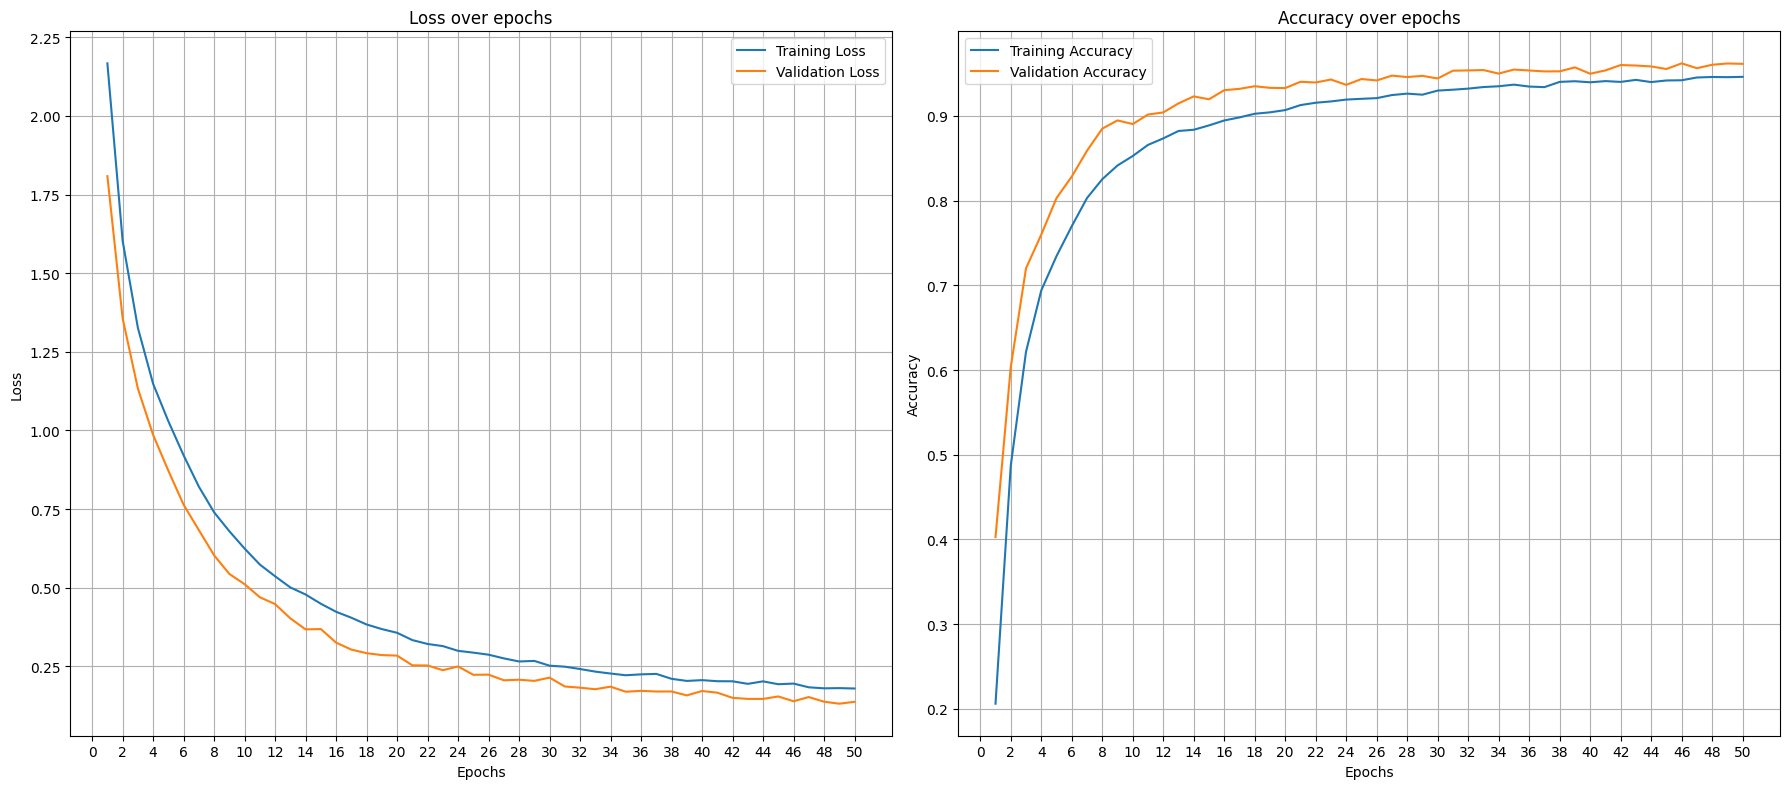

In [80]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 2))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 2)))  
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [81]:
test_labels = []
test_preds = []
test_running_loss = 0
with torch.no_grad():
    for idx, (data, target) in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = data.float().to(device)
        label = target.type(torch.uint8).to(device)
        y_pred = model1(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        test_labels.extend(label.cpu().detach())
        test_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)
        test_running_loss += loss.item()

test_loss = test_running_loss / (idx + 1)

test_accuracy = sum(1 for x,y in zip(test_preds, test_labels) if x==y) / len(test_labels)

print("-" * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("-" * 30)

100%|██████████| 20/20 [00:01<00:00, 16.54it/s]

------------------------------
Test Loss: 0.1356
Test Accuracy: 0.9608
------------------------------
